# Exoplanet Prediction 

### import packages

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC

### Read training dataset

Kepler data are available in two cadences, long cadence (LC) and short cadence (SC). Each cadence is composed of multiple 6.02-s exposures with associated 0.52-s readout times (Gilliland et al. 2010b).  The LC data integrate over 270 exposures to give 29.4-min observations, whereas the SC data contain nine exposures giving one data point every 58.9-s

In [34]:
# read training data
# Assume data is Kepler long-cadence data at 30 minute increments
df_train = pd.read_csv('exoTrain.csv')
df_train.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


Plot sample time history with planet

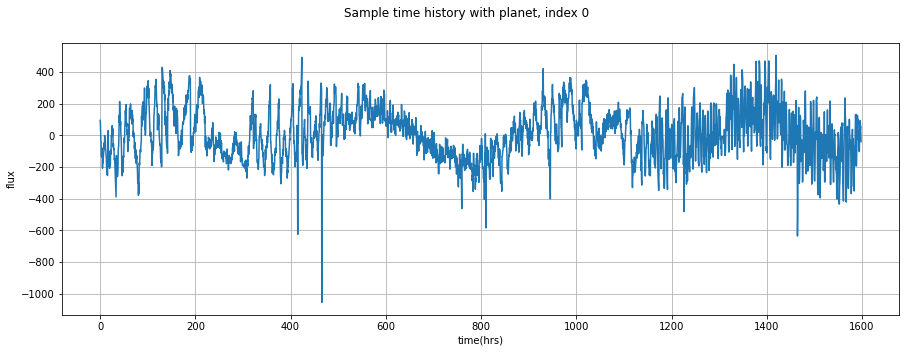

In [35]:
amp = df_train.iloc[0,1:]
time = np.arange(0,len(amp))*(30/60)
fig, ax = plt.subplots(1,figsize=(15,5))
fig.suptitle('Sample time history with planet, index 0')
ax.plot(time,amp)
ax.set(xlabel='time(hrs)', ylabel='flux')
ax.grid()

Smooth time history using a Savitzky-Golay filter

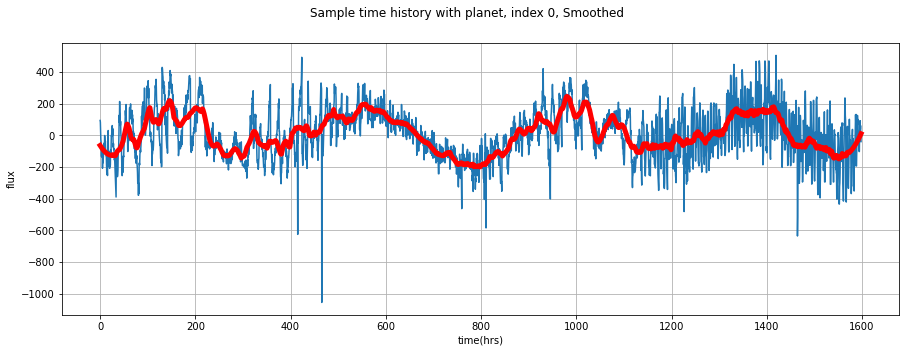

In [36]:
amp_s = scipy.signal.savgol_filter(amp, 101, 2) # window size 51, polynomial order 3
fig, ax = plt.subplots(1,figsize=(15,5))
fig.suptitle('Sample time history with planet, index 0, Smoothed')
ax.plot(time,amp)
ax.plot(time,amp_s,'r-',lw=5)
ax.set(xlabel='time(hrs)', ylabel='flux')
ax.grid()

Subtract the trend from the time history

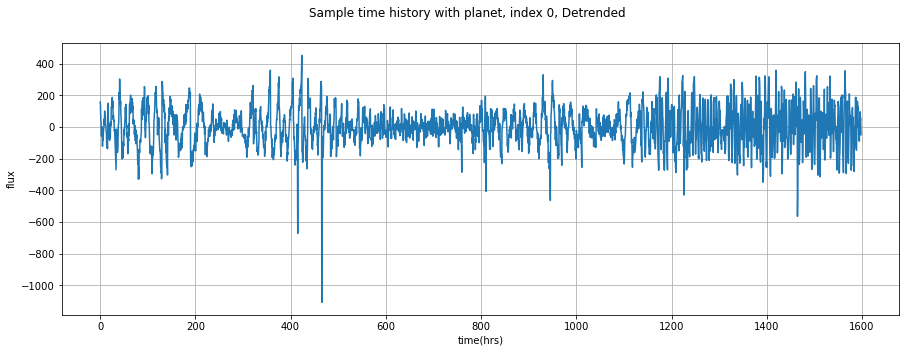

In [37]:
amp_dt = amp - amp_s
fig, ax = plt.subplots(1,figsize=(15,5))
fig.suptitle('Sample time history with planet, index 0, Detrended')
ax.plot(time,amp_dt)
ax.set(xlabel='time(hrs)', ylabel='flux')
ax.grid()

Subtract the mean from the time history

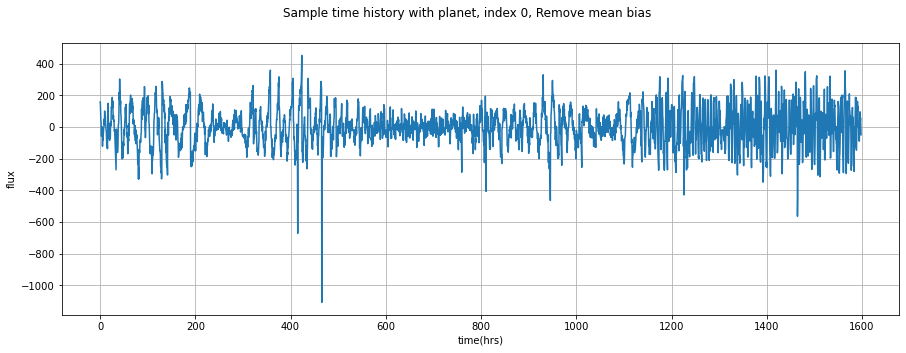

In [38]:
# subtract mean
amp_m = amp_dt - amp_dt.mean()
fig, ax = plt.subplots(1,figsize=(15,5))
fig.suptitle('Sample time history with planet, index 0, Remove mean bias')
ax.plot(time,amp_m)
ax.set(xlabel='time(hrs)', ylabel='flux')
ax.grid()

Normalize using standard deviation

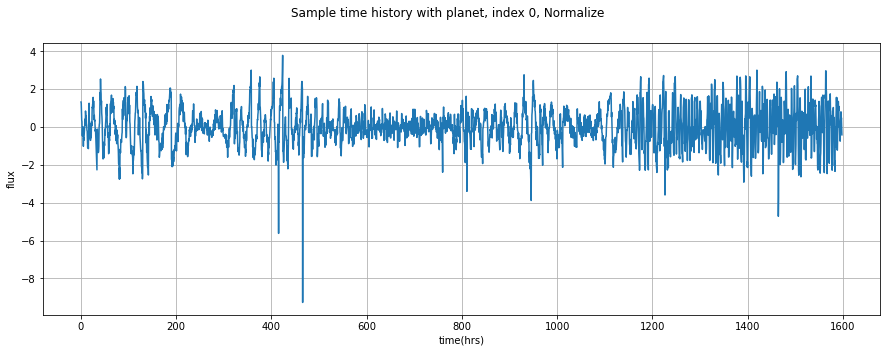

In [39]:
# normalize by standard deviation
amp_norm = amp_m / amp_m.std()
fig, ax = plt.subplots(1,figsize=(15,5))
fig.suptitle('Sample time history with planet, index 0, Normalize')
ax.plot(time,amp_norm)
ax.set(xlabel='time(hrs)', ylabel='flux')
ax.grid()

Calculate power spectral density of the signal

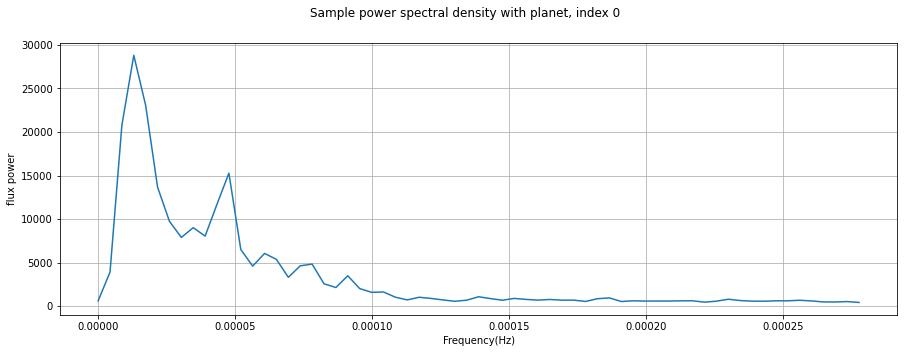

In [40]:
sps = 1 / (30 *60) # samples per second
nt = len(time) # total points in record
nr = 128  # number points per analysis window
df = sps / (nr -1) # delta frequency in hertz
[freq, psd] = signal.welch(amp_norm,fs=sps,window='hann',nperseg=nr)
fig, ax = plt.subplots(1,figsize=(15,5))
fig.suptitle('Sample power spectral density with planet, index 0')
ax.plot(freq,psd)
ax.set(xlabel='Frequency(Hz)', ylabel='flux power')
ax.grid()

### Generate training dataframe by applying normalizing function

In [41]:
# normalize data function
def normalize_data(amp):
    # window size 101, polynomial order 2
    amp_s = scipy.signal.savgol_filter(amp, 101, 2)
    return (amp - amp_s - amp_dt.mean()) / amp_m.std()

# return just the psd value for pandas apply method
def psd_calculation(y,sps,window,nr):
    f,p = signal.welch(y,sps,window,nr)
    return p /  (p.max())

### Generate training dataframe by applying normalizing function

In [42]:
# dataframe with just flux
df_train_flux = df_train.iloc[:,1:]
# normulize
df_train_flux_norm = df_train_flux.apply(normalize_data,axis=1,result_type='broadcast')
df_train_flux_psd = df_train_flux_norm.apply(psd_calculation,axis=1,sps=sps,window='hann',nr=nr,result_type='expand')
df_train_flux_psd.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0.020614,0.135070,0.721895,1.0,0.800153,0.474257,0.337921,0.273703,0.312585,0.278999,...,0.019498,0.019251,0.020897,0.020788,0.023064,0.020380,0.016443,0.016220,0.017772,0.014350
1,0.026410,0.173083,0.799223,1.0,0.733211,0.592340,0.510293,0.417882,0.447526,0.367989,...,0.020408,0.022146,0.024035,0.022554,0.020745,0.021096,0.018541,0.016803,0.020791,0.012110
2,0.037043,0.145601,0.779544,1.0,0.434480,0.380130,0.333944,0.183029,0.142429,0.100937,...,0.003969,0.003974,0.004589,0.005452,0.005413,0.004714,0.004688,0.004816,0.005111,0.003375
3,0.026121,0.110336,0.683197,1.0,0.569171,0.420370,0.396738,0.286639,0.212166,0.166486,...,0.017841,0.019701,0.021252,0.017186,0.018194,0.018060,0.025004,0.025154,0.026320,0.018752
4,0.040418,0.144483,0.673604,1.0,0.662332,0.589637,0.493189,0.418583,0.508252,0.489096,...,0.020479,0.023176,0.019799,0.018406,0.018224,0.016832,0.017380,0.017343,0.017413,0.011913


Check that this wored by ploting index 0 and comparing to above plots

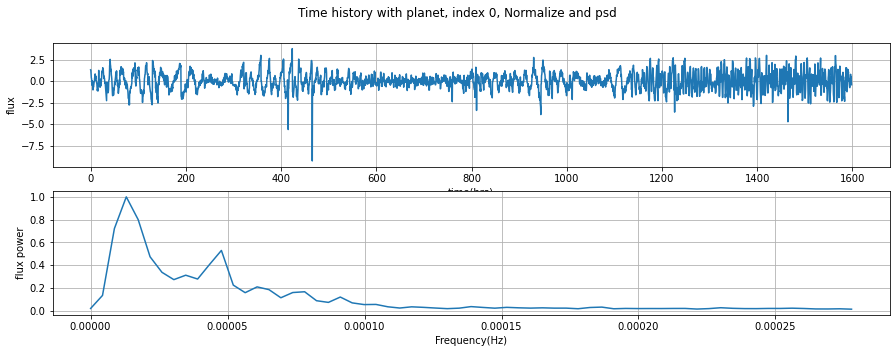

In [43]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(15,5))
fig.suptitle('Time history with planet, index 0, Normalize and psd')

ax1.plot(time,df_train_flux_norm.iloc[0,:])
ax1.set(xlabel='time(hrs)', ylabel='flux')
ax1.grid()

ax2.plot(freq,df_train_flux_psd.iloc[0,:])
ax2.set(xlabel='Frequency(Hz)', ylabel='flux power')
ax2.grid()

### Read test dataset

In [44]:
df_test = pd.read_csv('exoTest.csv')
df_test.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84


### Generate testing dataframe.¶

In [45]:
# dataframe with just flux
df_test_flux = df_test.iloc[:,1:]
# normulize
df_test_flux_norm = df_test_flux.apply(normalize_data,axis=1,result_type='broadcast')
df_test_flux_psd = df_test_flux_norm.apply(psd_calculation,axis=1,sps=sps,window='hann',nr=nr,result_type='expand')
df_test_flux_psd.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0.020662,0.132182,0.783475,1.0,0.662712,0.518482,0.561303,0.381326,0.283186,0.164086,...,0.031313,0.031240,0.034010,0.033558,0.037093,0.031075,0.031014,0.028631,0.040112,0.029947
1,0.029365,0.113972,0.637255,1.0,0.960290,0.981633,0.861194,0.638265,0.421576,0.331140,...,0.006258,0.005964,0.008471,0.006829,0.006067,0.007767,0.007360,0.006719,0.011216,0.009346
2,0.035535,0.139888,0.728956,1.0,0.706979,0.670148,0.735064,0.653790,0.587480,0.363142,...,0.021450,0.029452,0.034083,0.028756,0.026082,0.025571,0.027798,0.027442,0.032001,0.021126
3,0.033817,0.113369,0.621986,1.0,0.713367,0.631802,0.651263,0.546189,0.531335,0.411641,...,0.008885,0.008748,0.007307,0.006983,0.008224,0.007885,0.007361,0.008602,0.007317,0.003409
4,0.018130,0.104106,0.624638,1.0,0.721001,0.767424,0.773657,0.580103,0.613782,0.535055,...,0.009619,0.013012,0.013470,0.014451,0.013460,0.016563,0.017047,0.012994,0.013004,0.007687


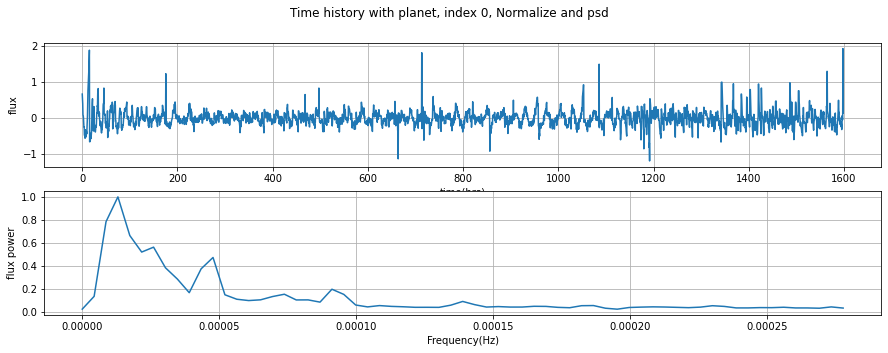

In [46]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(15,5))
fig.suptitle('Time history with planet, index 0, Normalize and psd')

ax1.plot(time,df_test_flux_norm.iloc[0,:])
ax1.set(xlabel='time(hrs)', ylabel='flux')
ax1.grid()

ax2.plot(freq,df_test_flux_psd.iloc[0,:])
ax2.set(xlabel='Frequency(Hz)', ylabel='flux power')
ax2.grid()

###  Support Vector Machine

In [47]:
# training and test data
X_train = df_train_flux_psd
y_train = df_train['LABEL']
X_test = df_test_flux_psd
y_test = df_test['LABEL']

In [48]:
weights = {1:1.0, 2:5.0}
svcf = SVC(kernel='linear',C=1,class_weight=weights).fit(X_train,y_train)
y_train_pred = svcf.predict(X_train)
y_test_pred = svcf.predict(X_test)

In [49]:
print(confusion_matrix(y_train, y_train_pred, labels=[1, 2]))
print(classification_report(y_train, y_train_pred, labels=[1,2]))

[[5049    1]
 [  22   15]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5050
           2       0.94      0.41      0.57        37

    accuracy                           1.00      5087
   macro avg       0.97      0.70      0.78      5087
weighted avg       1.00      1.00      0.99      5087



In [50]:
print(confusion_matrix(y_test, y_test_pred, labels=[1, 2]))
print(classification_report(y_test, y_test_pred, labels=[1,2]))

[[564   1]
 [  2   3]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       565
           2       0.75      0.60      0.67         5

    accuracy                           0.99       570
   macro avg       0.87      0.80      0.83       570
weighted avg       0.99      0.99      0.99       570



### Lets try again using a different method of normalizing the time history

Revised function for normalizing the data. Use Differencing in place of Savitzky-Golay filter.  Also increase the psd ananlysis frequency resolution using nr = 256

In [51]:
sps = 1 / (30 *60) # samples per second
nt = len(time) # total points in record
nr = 256  # number points per analysis window
df = sps / (nr -1) # delta frequency in hertz
freq = np.arange(0,df*(nr/2+1),df)
#[freq, psd] = signal.welch(amp_norm,fs=sps,window='hann',nperseg=nr)
# normalize data function
def normalize_data(amp):
    amp_dt = amp - amp.shift()
    amp_n = (amp - amp.shift()) / amp_dt.std()
    amp_n[0] = amp_n[1]
    return amp_n

### Generate training dataframe by applying normalizing function


In [52]:
# dataframe with just flux
df_train_flux = df_train.iloc[:,1:]
# normulize
df_train_flux_norm = df_train_flux.apply(normalize_data,axis=1,result_type='broadcast')
df_train_flux_psd = df_train_flux_norm.apply(psd_calculation,axis=1,sps=sps,window='hann',nr=nr,result_type='expand')
df_train_flux_psd.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,0.005545,0.006198,0.014401,0.036831,0.069044,0.086425,0.102932,0.171703,0.265967,0.191194,...,0.662874,0.529545,0.505473,0.374988,0.375026,0.536532,0.360769,0.436912,0.690425,0.516859
1,0.000873,0.003621,0.008580,0.024588,0.045459,0.051813,0.044946,0.091608,0.102400,0.121929,...,0.255909,0.301673,0.251883,0.170566,0.187214,0.224107,0.246709,0.313977,0.340715,0.192819
2,0.004510,0.017374,0.040112,0.092176,0.133971,0.219435,0.209582,0.163790,0.210030,0.188459,...,0.305031,0.220274,0.207285,0.246738,0.248321,0.252768,0.283725,0.217639,0.248297,0.265762
3,0.004857,0.019651,0.013677,0.034580,0.062918,0.099621,0.096178,0.078262,0.084004,0.112097,...,0.467356,0.484146,0.520820,0.755946,0.870499,0.640534,0.596042,0.599737,0.830408,0.581846
4,0.002105,0.009051,0.014065,0.024044,0.032765,0.046234,0.051406,0.064592,0.073194,0.092479,...,0.162232,0.246599,0.228687,0.186312,0.282404,0.258037,0.205770,0.299643,0.237980,0.185040


Check that this wored by ploting index 0 and comparing to above plots

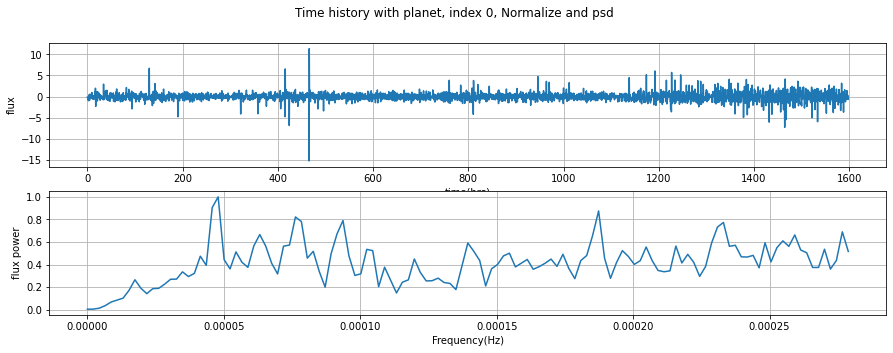

In [53]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(15,5))
fig.suptitle('Time history with planet, index 0, Normalize and psd')

ax1.plot(time,df_train_flux_norm.iloc[0,:])
ax1.set(xlabel='time(hrs)', ylabel='flux')
ax1.grid()

ax2.plot(freq,df_train_flux_psd.iloc[0,:])
ax2.set(xlabel='Frequency(Hz)', ylabel='flux power')
ax2.grid()

###  test dataset

In [54]:
#df_test = pd.read_csv('exoTest.csv')
df_test.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84


### Generate testing dataframe.

In [55]:
# dataframe with just flux
df_test_flux = df_test.iloc[:,1:]
# normulize
df_test_flux_norm = df_test_flux.apply(normalize_data,axis=1,result_type='broadcast')
df_test_flux_psd = df_test_flux_norm.apply(psd_calculation,axis=1,sps=sps,window='hann',nr=nr,result_type='expand')
df_test_flux_psd.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,0.004003,0.003261,0.006431,0.018438,0.042046,0.051486,0.054508,0.069833,0.088953,0.076751,...,0.412380,0.441890,0.493606,0.512093,0.420402,0.320975,0.525824,0.630056,0.686490,0.594244
1,0.003733,0.008075,0.009567,0.020191,0.026268,0.039846,0.050548,0.068087,0.102044,0.153820,...,0.078872,0.124335,0.083155,0.079988,0.078550,0.083970,0.088877,0.146648,0.200129,0.148530
2,0.008660,0.006410,0.009508,0.019289,0.039823,0.048411,0.065578,0.081178,0.090386,0.096316,...,0.431136,0.336162,0.387047,0.453001,0.469637,0.361128,0.374887,0.424148,0.547068,0.382361
3,0.000444,0.006501,0.015474,0.040702,0.057286,0.112418,0.125546,0.192098,0.204154,0.265906,...,0.224728,0.221687,0.237163,0.215264,0.262425,0.263793,0.238520,0.235989,0.224452,0.099203
4,0.000510,0.003175,0.007696,0.016095,0.032692,0.045680,0.067654,0.087131,0.119970,0.147655,...,0.213335,0.251897,0.302690,0.285294,0.232874,0.211693,0.227083,0.236400,0.251451,0.133128


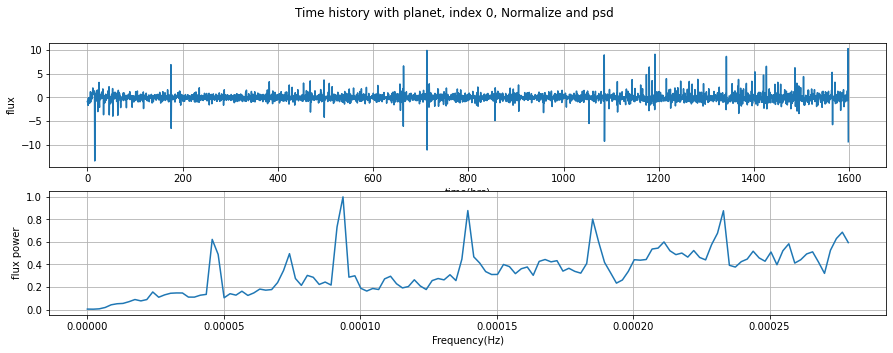

In [56]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(15,5))
fig.suptitle('Time history with planet, index 0, Normalize and psd')

ax1.plot(time,df_test_flux_norm.iloc[0,:])
ax1.set(xlabel='time(hrs)', ylabel='flux')
ax1.grid()

ax2.plot(freq,df_test_flux_psd.iloc[0,:])
ax2.set(xlabel='Frequency(Hz)', ylabel='flux power')
ax2.grid()

###  Support Vector Machine

In [57]:
# training and test data
X_train = df_train_flux_psd
y_train = df_train['LABEL']
X_test = df_test_flux_psd
y_test = df_test['LABEL']

In [58]:
weights = {1:1.0, 2:5.0}
svcf = SVC(kernel='linear',C=1,class_weight=weights).fit(X_train,y_train)
y_train_pred = svcf.predict(X_train)
y_test_pred = svcf.predict(X_test)

In [59]:
print(confusion_matrix(y_train, y_train_pred, labels=[1, 2]))
print(classification_report(y_train, y_train_pred, labels=[1,2]))

[[5049    1]
 [   1   36]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5050
           2       0.97      0.97      0.97        37

    accuracy                           1.00      5087
   macro avg       0.99      0.99      0.99      5087
weighted avg       1.00      1.00      1.00      5087



In [60]:
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[561   4]
 [  1   4]]
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       565
           2       0.50      0.80      0.62         5

    accuracy                           0.99       570
   macro avg       0.75      0.90      0.81       570
weighted avg       0.99      0.99      0.99       570

